# #Masks Throughout COVID-19: A Twitter Sentiment Analysis

## Modeling

## Table of contents
1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Prepping the data](#Step-1:-Prepping-the-data)

    - [Train-test split](#Train-test-split)
    
    
5. [Step 2: Modeling](#Step-2:-Modeling)

    - [Cross-validation](#Cross-validation)
    - [Parameter tuning](#Parameter-tuning)
    - [Train final model](#Train-final-model)


6. [Step 3: Reproducibility](#Step-3:-Reproducibility)
7. [Conclusions](#Conclusions)
8. [Acknowledgements](#Acknowledgements)

## Introduction

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

After scraping Twitter with [Twint](https://github.com/twintproject/twint), [Eric Blander](https://github.com/EricB10) and [I](https://github.com/p-szymo) used natural language processing (NLP) techniques to analyze the sentiment of tweets relating to masks and coronavirus.

Through text processing, exploratory data analysis and feature engineering, we looked for insights into how important words, topics, and subjectivity relate to sentiment.

These steps, as well as answers to some initial questions about the data and the project, can be seen in the previous [notebook](03_nlp_features_eda_notebook.ipynb).

In this notebook, we will create predictive models that classify tweets as *negative*, *neutral*, or *positive*. This will help us provide further insight and confirm our findings made during EDA.

## The problem domain

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

Within the U.S., the official narrative on masks within the early days of the pandemic was surprising, in that government bodies were claiming that masks were [ineffective](https://twitter.com/surgeon_general/status/1233725785283932160?lang=en) in stopping the spread. Eventually, there was a stark shift in this narrative toward the necessity of wearing masks to "[protect each other](https://twitter.com/surgeon_general/status/1264166726230573057?lang=en)". The difference in tweets about masks by the Surgeon General in February (which were overwhelmingly negative) and his tweets in May (overwhelmingly positive) paint an important yet unfortunate picture of how officials dropped the ball in the pandemic's early days.

We began to wonder whether there was a similar shift within the country as a whole. How has the country's attitude toward masks changed since the early days of COVID-19, or has it remained relatively constant? We decided to look to Twitter to investigate if we could develop a clearer picture of the country's mood during these crucial and trying months.

## Required libraries

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **scikit-learn**: The essential Machine Learning package in Python.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages (some are only needed in the [Reproducibility](#Step-3:-Reproducibility) section) that you may have to install:

- **nltk**: The essential natural language processing package.
- **gensim**: A more specialized natural language processing package.
- **textblob**: A supplementary package to enhance the nltk package.
- **vaderSentiment**: A sentiment analysis tool based on human-compiled data.
- **wordcloud**: A library focused on plotting word frequencies.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[functions](functions.py)**: Custom functions that we built for this project.

Run the cell below to import all of the necessary packages.

In [1]:
# standard packages
import numpy as np
import pandas as pd

# visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# modeling packages
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, confusion_matrix, classification_report

# ignore sklearn warnings
# (code from: https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# saving/loading packages
import gzip
import pickle

# custom functions and reload after editing
from functions import *
%load_ext autoreload
%autoreload 2

# Step 1: Prepping the data

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Load target/features DataFrame and word vector DataFrame.
- Check for any highly correlated variables.
- Combine DataFrames.
- Train-test split.

In [2]:
# load dataframe
with gzip.open('data/jan_thru_may_labeled_mask_tweets_model_prepped.pkl', 'rb') as hello:
    df = pickle.load(hello)

# confirm shape
df.shape

(575949, 19)

In [3]:
# confirm columns look correct
df.columns

Index(['sentiment', 'clean_tweet', 'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4',
       'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 'subjectivity_score',
       'february', 'march', 'april', 'may', 'replies', 'likes'],
      dtype='object')

In [4]:
# load word vector dataframe
with gzip.open('data/data_vec.pkl', 'rb') as hello:
    vectors_df = pickle.load(hello)

# confirm shape
vectors_df.shape

(575949, 3566)

- Check for any highly correlated continuous variables.

In [5]:
# columns to check
cont_cols = [
    'lda_0', 'lda_1', 'lda_2',
    'lda_3', 'lda_4', 'lda_5', 
    'lda_6', 'lda_7', 'lda_8', 
    'lda_9', 'subjectivity_score'
       ]

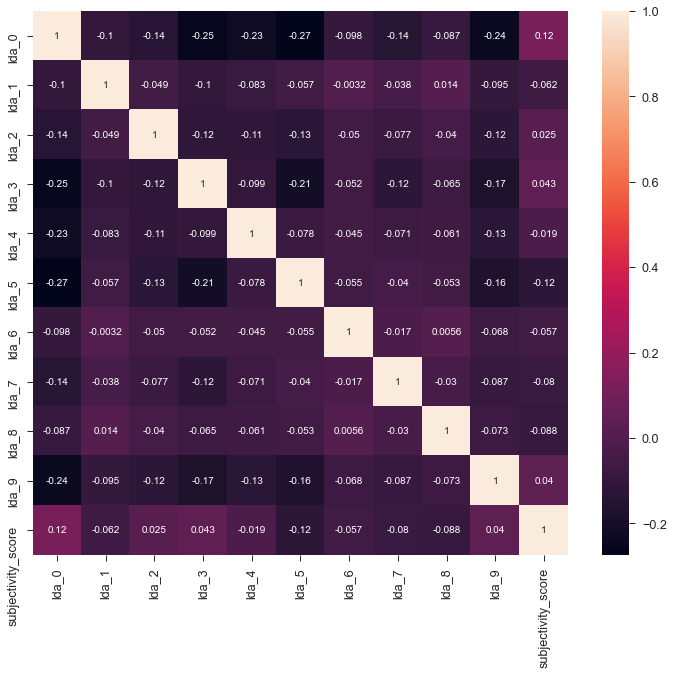

In [6]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

- Looks good! So we can go ahead and include all of these.
- Next, we'll combine the DataFrames.

In [7]:
# list of columns to use as features
feature_cols = [
    'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4',
    'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 
    'subjectivity_score', 'february', 'march', 
    'april', 'may', 'replies', 'likes'
]

In [8]:
%%time

# combine features columns and word vectors dataframe
X = pd.concat([df[feature_cols], vectors_df], axis=1)
y = df['sentiment']

X.shape, y.shape

CPU times: user 50.9 s, sys: 22.3 s, total: 1min 13s
Wall time: 1min 23s


((575949, 3583), (575949,))

## Train-test-split

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Use 70% of our data as a training set and 30% as a testing set.
- Since we want to see if our engineered features improve our models beyond those using only word vectors, we'll also create separate vector only training and testing sets.
- Our data is all be on the same scale (between 0 and 1), so no scaler is necessary.

In [9]:
%%time

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# create vectors-only training and test sets (removing the first 17 columns)
X_train_vec = X_train.iloc[:,17:]
X_test_vec = X_test.iloc[:,17:]

X_train.shape, X_test.shape, X_train_vec.shape, X_test_vec.shape

CPU times: user 43.7 s, sys: 54.6 s, total: 1min 38s
Wall time: 2min 8s


((403164, 3583), (172785, 3583), (403164, 3566), (172785, 3566))

# Step 2: Modeling

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- We'll test out untuned Naive Bayes (Bernoulli and Multinomial) and Decision Tree models on both our vectors-only sets and vectors-plus-features sets.
- Then we'll cross-validate.
- Then we'll tune parameters.
- Finally, we can train and save a final model.

### Bernoulli Naive Bayes - vectors only

In [11]:
%%time

# create Bernoulli Naive Bayes object
bnb_vec = BernoulliNB()

# train model
benaba_vec = bnb_vec.fit(X_train_vec, y_train)

# predict on train and test data
y_train_pred_bnb_vec = benaba_vec.predict(X_train_vec)
y_test_pred_bnb_vec = benaba_vec.predict(X_test_vec)

CPU times: user 2min 50s, sys: 1min 26s, total: 4min 17s
Wall time: 4min 39s


In [12]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_bnb_vec)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_bnb_vec, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_bnb_vec, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_bnb_vec, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_bnb_vec)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_bnb_vec, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_bnb_vec, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_bnb_vec, average="weighted")}')


print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_bnb_vec, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_bnb_vec))

-----TRAIN-----
Accuracy: 0.7157608318203014
F1 score: 0.7176953642255267
Recall: 0.7157608318203014
Precision: 0.7257952387590993

-----TEST-----
Accuracy: 0.7127528431287438
F1 score: 0.7147691967836526
Recall: 0.7127528431287438
Precision: 0.7228616573206086

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.74      0.70      0.72     66413
    positive       0.59      0.76      0.66     34605
     neutral       0.78      0.71      0.74     71767

    accuracy                           0.71    172785
   macro avg       0.70      0.72      0.71    172785
weighted avg       0.72      0.71      0.71    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[46191  9548 10674]
 [ 4383 26204  4018]
 [12124  8885 50758]]


- Not bad! Very well fit and decent F1 scores, though it struggles a bit in identifying *positive* tweets.
- Let's take a quick look at important features and confusion matrices.

#### Feature importances

In [13]:
# sorted features per class by importance
pos_class_prob_sorted = benaba_vec.feature_log_prob_[0, :].argsort()
neu_class_prob_sorted = benaba_vec.feature_log_prob_[1, :].argsort()
neg_class_prob_sorted = benaba_vec.feature_log_prob_[2, :].argsort()

# printout of each class's top 10
print(f'Positive tweets:\n{", ".join(list(np.take(X_train_vec.columns, pos_class_prob_sorted[:10])))}\n')
print(f'Neutral tweets:\n{", ".join(list(np.take(X_train_vec.columns, neu_class_prob_sorted[:10])))}\n')
print(f'Negative tweets:\n{", ".join(list(np.take(X_train_vec.columns, neg_class_prob_sorted[:10])))}')

Positive tweets:
#wholesale, okhand, #sale, smilingfacewith3, faceblowingakiss, #healthy, #safe, purpleheart, blueheart, twohearts

Neutral tweets:
#love, celebrate, smilingfacewithheart, smilingfacewith3, okhand, incompetent, incompetence, improve, violent, loss

Negative tweets:
iniran, assault, thief, incompetence, suicide, germany's, #fight, fails, threatens, declares


#### Confusion matrix

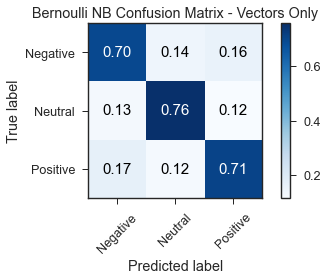

In [14]:
cm_benaba = confusion_matrix(y_test, y_test_pred_bnb_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

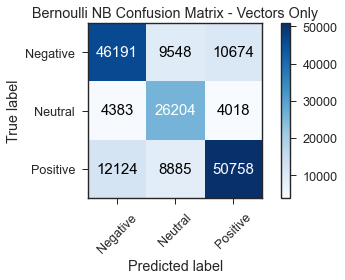

In [15]:
cm_benaba = confusion_matrix(y_test, y_test_pred_bnb_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=False,
                      title='Bernoulli NB Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

- It's interesting that hashtags and emojis are so important for *positive* and *neutral* tweets, but not *negative* tweets.
- Could it be that tweets with these "words" tend to be more *positive*, or does the VADER sentiment analyzer weight them more positively? It's difficult to tell here, but maybe in the future, we can try removing hashtags and emojis and see how that affects our results.

### Bernoulli Naive Bayes - numerical data + vectors

In [17]:
%%time

# create Bernoulli Naive Bayes object
bnb_combo = BernoulliNB()

# train model
benaba_combo = bnb_combo.fit(X_train, y_train)

# predict on corresponding train and test data
y_pred_train_bnb_combo = benaba_combo.predict(X_train)
y_pred_test_bnb_combo = benaba_combo.predict(X_test)

CPU times: user 3min 4s, sys: 1min 50s, total: 4min 55s
Wall time: 5min 26s


In [18]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_pred_train_bnb_combo)}')
print(f'F1 score: {f1_score(y_train, y_pred_train_bnb_combo, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_pred_train_bnb_combo, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_pred_train_bnb_combo, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_pred_test_bnb_combo)}')
print(f'F1 score: {f1_score(y_test, y_pred_test_bnb_combo, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred_test_bnb_combo, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_pred_test_bnb_combo, average="weighted")}')


print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_pred_test_bnb_combo, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_pred_test_bnb_combo))

-----TRAIN-----
Accuracy: 0.6254229048228512
F1 score: 0.6347419976743295
Recall: 0.6254229048228512
Precision: 0.6747955930823033

-----TEST-----
Accuracy: 0.6233237838932778
F1 score: 0.6325810019992972
Recall: 0.6233237838932778
Precision: 0.673085341549466

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.72      0.59      0.65     66413
    positive       0.42      0.75      0.54     34605
     neutral       0.75      0.59      0.66     71767

    accuracy                           0.62    172785
   macro avg       0.63      0.64      0.62    172785
weighted avg       0.67      0.62      0.63    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[39274 17258  9881]
 [ 4331 25937  4337]
 [10754 18523 42490]]


- Wow! Much worse, with similar problems identifying *positive* tweets.
- A quick look at important features below shoes no major differences.
- The confusion matrices show that *neutral* tweets are still the most effectively predicted, without any loss by using the other features.

#### Feature importances

In [19]:
# sorted features per class by importance
pos_class_prob_sorted = benaba_combo.feature_log_prob_[0, :].argsort()
neu_class_prob_sorted = benaba_combo.feature_log_prob_[1, :].argsort()
neg_class_prob_sorted = benaba_combo.feature_log_prob_[2, :].argsort()

# printout of each class's top 10
print(np.take(X.columns, pos_class_prob_sorted[:10]))
print(np.take(X.columns, neu_class_prob_sorted[:10]))
print(np.take(X.columns, neg_class_prob_sorted[:10]))

Index(['#wholesale', '#sale', 'okhand', 'faceblowingakiss', 'smilingfacewith3',
       '#healthy', '#safe', 'purpleheart', 'smilingfacewithheart', '#love'],
      dtype='object')
Index(['improve', '#love', 'smilingfacewith3', 'smilingfacewithheart',
       'celebrate', 'okhand', 'incompetence', 'incompetent', 'creative',
       'illegal'],
      dtype='object')
Index(['iniran', 'assault', 'thief', 'suicide', 'incompetence', 'germany's',
       'fails', '#fight', 'threatens', 'violence'],
      dtype='object')


#### Confusion matrix

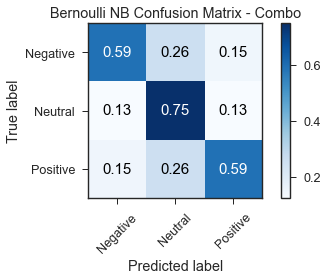

In [20]:
cm_benaba = confusion_matrix(y_test, y_pred_test_bnb_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix - Combo', cmap=plt.cm.Blues)

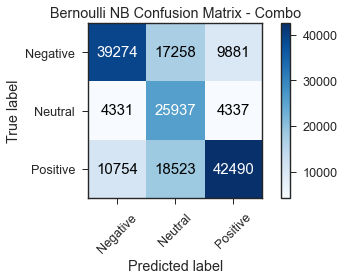

In [21]:
cm_benaba = confusion_matrix(y_test, y_pred_test_bnb_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=False,
                      title='Bernoulli NB Confusion Matrix - Combo', cmap=plt.cm.Blues)

### Multinomial Naive Bayes - vectors only

In [22]:
%%time

# create Multinomial Naive Bayes object
mnb_vec = MultinomialNB()

# train model
munaba_vec = mnb_vec.fit(X_train_vec, y_train)

# predict on corresponding train and test data
y_train_pred_mnb_vec = munaba_vec.predict(X_train_vec)
y_test_pred_mnb_vec = munaba_vec.predict(X_test_vec)

CPU times: user 27.2 s, sys: 16.8 s, total: 44 s
Wall time: 35.1 s


In [23]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_mnb_vec)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_mnb_vec, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_mnb_vec, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_mnb_vec, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_mnb_vec)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_mnb_vec, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_mnb_vec, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_mnb_vec, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_mnb_vec, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_mnb_vec))

-----TRAIN-----
Accuracy: 0.692006230715044
F1 score: 0.6774887034891885
Recall: 0.692006230715044
Precision: 0.6965605413145178

-----TEST-----
Accuracy: 0.688057412391122
F1 score: 0.6733511536832583
Recall: 0.688057412391122
Precision: 0.6918766959418424

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.70      0.75      0.72     66413
    positive       0.72      0.33      0.45     34605
     neutral       0.67      0.80      0.73     71767

    accuracy                           0.69    172785
   macro avg       0.70      0.63      0.64    172785
weighted avg       0.69      0.69      0.67    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[49856  2441 14116]
 [ 9189 11531 13885]
 [12122  2146 57499]]


- Similar results but worse across the board.
- We'll see if our features improve it.

### Multinomial Naive Bayes - numerical data + vectors

In [25]:
%%time

# create Multinomial Naive Bayes object
mnb_combo = MultinomialNB()

# train model
munaba_combo = mnb_combo.fit(X_train, y_train)

# predict on corresponding train and test data
y_train_pred_mnb_combo = munaba_combo.predict(X_train)
y_test_pred_mnb_combo = munaba_combo.predict(X_test)

CPU times: user 43.7 s, sys: 42 s, total: 1min 25s
Wall time: 1min 26s


In [26]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_mnb_combo)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_mnb_combo, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_mnb_combo, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_mnb_combo, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_mnb_combo)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_mnb_combo, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_mnb_combo, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_mnb_combo, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_mnb_combo, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_mnb_combo))

-----TRAIN-----
Accuracy: 0.6970711670684883
F1 score: 0.6885496709793402
Recall: 0.6970711670684883
Precision: 0.6990540461976077

-----TEST-----
Accuracy: 0.6945741817866135
F1 score: 0.6860664695731379
Recall: 0.6945741817866135
Precision: 0.6962108790803943

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.70      0.74      0.72     66413
    positive       0.71      0.42      0.52     34605
     neutral       0.69      0.79      0.73     71767

    accuracy                           0.69    172785
   macro avg       0.70      0.65      0.66    172785
weighted avg       0.70      0.69      0.69    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[49245  3202 13966]
 [ 8829 14390 11386]
 [12748  2642 56377]]


- Interesting! Actually a very slight increase here, but still not enough to beat our first model.

### Decision Tree - untuned - vectors only

⏰ NOTE: Next cell takes several minutes to run.

In [ ]:
%%time

# basic decision tree with class weights balanced
tree_vec = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
tree_vec.fit(X_train_vec, y_train)

# predict on train and test data
y_train_pred_tree_vec = tree_vec.predict(X_train_vec)
y_test_pred_tree_vec = tree_vec.predict(X_test_vec)

In [ ]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_tree_vec)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_tree_vec, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_tree_vec, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_tree_vec, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_tree_vec)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_tree_vec, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_tree_vec, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_tree_vec, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_tree_vec, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_tree_vec))

- COMMENT

#### Feature importances

In [ ]:
features_dict = dict(zip(X_train_vec.columns, tree_vec.feature_importances_))
sorted_d = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_d

In [ ]:
# top 10 most important features
tree_importance = [x[1] for x in sorted_d]

# prettify the graph
plt.figure(figsize=(12,8))
plt.title('Decision Tree Feature Importances', fontsize=25, pad=15)
plt.xlabel('Feature', fontsize=22, labelpad=15)
plt.ylabel('Gini Importance', fontsize=22, labelpad=15)
plt.ylim(bottom=0.006, top=0.016)
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)

# plot
plt.bar([x[0] for x in sorted_d], tree_importance)

# # prepare to display and save
plt.tight_layout()
# uncomment to save
plt.savefig('charts/tree_vec_untuned_feature_importance.png', bbox_inches='tight', transparent=True)

plt.show()

#### Confusion matrix

In [ ]:
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

In [ ]:
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

### Decision Tree - untuned - numerical data and vectors

In [ ]:
%%time

# basic decision tree with class weights balanced
tree_combo = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
tree_combo.fit(X_train, y_train)

# predict on train and test data
y_train_pred_tree_combo = tree_combo.predict(X_train)
y_test_pred_tree_combo = tree_combo.predict(X_test)

In [ ]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_tree_combo)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_tree_combo, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_tree_combo, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_tree_combo, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_tree_combo)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_tree_combo, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_tree_combo, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_tree_combo, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_tree_combo, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_tree_combo))

- COMMENT

#### Feature importances

In [ ]:
features_dict = dict(zip(X.columns, tree_combo.feature_importances_))
sorted_d = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_d

In [ ]:
# top 10 most important features
tree_importance = [x[1] for x in sorted_d]

plt.bar([x[0] for x in sorted_d], tree_importance)
plt.xticks(rotation=80)
plt.show()

#### Confusion Matrix

In [ ]:
cm_tree = confusion_matrix(y_test, y_pred_tree_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix - Combo', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

In [ ]:
cm_tree = confusion_matrix(y_test, y_pred_tree_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix - Combo', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

## Cross-validation

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- We'll see which of these generalizes the best on unseen data using cross-validation.
- We'll use 10 stratified folds and F1 score as our metric for this step.

In [ ]:
%%time

# instantiate baseline model
bnb_classifier = BernoulliNB()

# cross_val_score returns a list of the scores, which I can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(bnb_classifier, X.iloc[:,17:], y, scoring='f1_weighted', cv=10, n_jobs=-1)
plt.hist(cv_scores)
plt.title(f'Average score: {np.mean(cv_scores)}')
plt.show();

# Decision Tree - Tuned - vectors only

In [ ]:
%%time

# basic decision tree with class weights balanced
tree_vec_tuned = DecisionTreeClassifier(class_weight='balanced', max_depth=1000, random_state=99)

# fit training data
tree_vec_tuned.fit(X_train_vec, y_train)

# predict on test data
y_pred_tree_vec_tuned = tree_vec_tuned.predict(X_test_vec)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_tree_vec_tuned))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_tree_vec_tuned, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_tree_vec_tuned, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_tree_vec_tuned, average='weighted'))

In [ ]:
features_dict = dict(zip(X_train_vec.columns, tree_vec_tuned.feature_importances_))
sorted_d = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_d

In [ ]:
# top 10 most important features
tree_importance = [x[1] for x in sorted_d]

# prettify the graph
plt.figure(figsize=(12,8))
plt.title('Decision Tree Feature Importances', fontsize=25, pad=15)
plt.xlabel('Feature', fontsize=22, labelpad=15)
plt.ylabel('Gini Importance', fontsize=22, labelpad=15)
plt.ylim(bottom=0.006, top=0.016)
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)

# plot
plt.bar([x[0] for x in sorted_d], tree_importance)

# # prepare to display and save
plt.tight_layout()
# uncomment to save
plt.savefig('charts/tuned_tree_feature_importance.png', bbox_inches='tight', transparent=True)

plt.show()

### Confusion Matrix

In [ ]:
cm_tree = confusion_matrix(y_test, y_pred_tree_vec_tuned)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

In [ ]:
cm_tree = confusion_matrix(y_test, y_pred_tree_vec_tuned)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

# Decision Tree - Tuned - vectors only - v2

In [ ]:
%%time

# basic decision tree with class weights balanced
tree_vec_tuned2 = DecisionTreeClassifier(class_weight='balanced', max_depth=500, random_state=99)

# fit training data
tree_vec_tuned2.fit(X_train_vec, y_train)

# predict on test data
y_pred_tree_vec_tuned2 = tree_vec_tuned2.predict(X_test_vec)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_tree_vec_tuned2))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_tree_vec_tuned2, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_tree_vec_tuned2, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_tree_vec_tuned2, average='weighted'))

In [ ]:
%%time

# basic decision tree with class weights balanced
tree_vec_tuned2 = DecisionTreeClassifier(class_weight='balanced', max_depth=500, random_state=99)

# fit training data
tree_vec_tuned2.fit(X_train_vec, y_train)

# predict on test data
y_pred_tree_vec_tuned2 = tree_vec_tuned2.predict(X_test_vec)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_tree_vec_tuned2))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_tree_vec_tuned2, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_tree_vec_tuned2, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_tree_vec_tuned2, average='weighted'))

In [ ]:
ytrainpreds=tree_vec_tuned2.predict(X_train_mm_vec)
accuracy_score(y_train, ytrainpreds)

In [ ]:
features_dict = dict(zip(X_train_vec.columns, tree_vec_tuned.feature_importances_))
sorted_d = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_d

In [ ]:
# top 10 most important features
tree_importance = [x[1] for x in sorted_d]

# prettify the graph
plt.figure(figsize=(12,8))
plt.title('Decision Tree Feature Importances', fontsize=25, pad=15)
plt.xlabel('Feature', fontsize=22, labelpad=15)
plt.ylabel('Gini Importance', fontsize=22, labelpad=15)
plt.ylim(bottom=0.006, top=0.016)
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)

# plot
plt.bar([x[0] for x in sorted_d], tree_importance)

# # prepare to display and save
plt.tight_layout()
# uncomment to save
plt.savefig('charts/tuned_tree_feature_importance.png', bbox_inches='tight', transparent=True)

plt.show()

### Confusion Matrix

In [ ]:
cm_tree = confusion_matrix(y_test, y_pred_tree_vec_tuned)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

In [ ]:
cm_tree = confusion_matrix(y_test, y_pred_tree_vec_tuned)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

# Step 3: Reproducibility

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Below are the required packages and other information.

In [ ]:
%load_ext watermark
%watermark -a 'Joshua Szymanowski' -nmv --packages numpy,pandas,geopandas,sklearn,matplotlib,seaborn,pickle,gzip,itertools

In [ ]:
%%time

# standard packages
import numpy as np
import pandas as pd

# visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# text processing/nlp packages
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

# modeling packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, confusion_matrix, classification_report

# saving/loading packages
import gzip
import pickle

# custom functions
from functions import *

# load dataframe
with gzip.open('data/jan_thru_may_labeled_mask_tweets.pkl', 'rb') as hello:
    df = pickle.load(hello)
    
# create stop words list
stop_words = stopwords.words('english')
# add search term words and hashtags to the list
stop_words += ['mask', '#mask',
               'masks', '#masks',
               'face', '#face',
               'facemask', '#facemask',
               'facemasks', '#facemasks', 
               'covid', '#covid',
               'covid19', '#covid19',
               'corona', '#corona',
               'coronavirus', '#coronavirus',
               'rona', '#rona',
               'virus', '#virus',
               'viral', '#viral',
               'viruses', '#viruses']
# very common/conflicting stop words discovered during eda
eda_stop_words = ['wear', 'wearing', 'get', 'one', 'people',
                  'us', 'like', 'n95', 'go', 'going', 'would', 
                  'surgical', 'via', 'also', 'use', 'even', 'know']
stop_words += eda_stop_words

# create column of processed text
df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x, stop_words))

# custom pattern to tokenize words -- includes hashtags, words with numbers, and contractions
pattern = "(#?[a-zA-Z]+[0-9]*(?:'[a-z]+)?)"

# instantiate a document-term matrix using TfidfVectorizer
# only take words with at least 250 appearances
tf_idf = TfidfVectorizer(min_df=250, token_pattern=pattern)

# run vectorizor
data_tf_idf = tf_idf.fit_transform(df.clean_tweet)

# convert to DataFrame
data_vec = pd.DataFrame(data_tf_idf.toarray(), columns=tf_idf.get_feature_names())

    #----IMPORTANT NOTE----#
# Our corpus has changed slightly after updating the clean_text function, 
# so we will be loading the original corpus, in order to keep our original topics.
# If you wish to create new topics, uncomment commented code below.

# # one of the required inputs is a term-document matrix
# tdm = data_vec.transpose()
# tdm.head()

# # put the term-document matrix into a new gensim format, 
# # from df ==> sparse matrix ==> gensim corpus
# # NOTE: MAY TAKE A FEW MINUTES
# sparse_counts = csr_matrix(tdm)
# corpus = Sparse2Corpus(sparse_counts)

# # gensim also requires dictionary of the all terms and their respective location in the term-document matrix
# id2word = dict((v, k) for k, v in tf_idf.vocabulary_.items())

# # create the topics
# lda = LdaModel(
#                 corpus=corpus, 
#                 id2word=id2word, 
#                 num_topics=10, 
#                 passes=100, 
#                 iterations=100
#             )

    #----IMPORTANT NOTE----#
# If you chose to create your own corpus/topics, comment out these cells

# load gensim corpus
with gzip.open('data/gensim_corpus_orig.pkl', 'rb') as hello_c:
    corpus = pickle.load(hello_c)
# load vocab location dictionary
with gzip.open('data/gensim_id2word_orig.pkl', 'rb') as hello_i:
    id2word = pickle.load(hello_i)
# load topics
with gzip.open('models/lda_10topics_100passes.pkl', 'rb') as hello:
    lda = pickle.load(hello)
#-----------------------------#

# corpus from LDA model
corpus_transformed = lda[corpus]

# convert lda tuples to dictionary
lda_topics_dict = [dict(x) for x in corpus_transformed]

# convert list of lda topic weights to dataframe
lda_df = pd.DataFrame(lda_topics_dict)

# rename columns
lda_df.rename(columns={i: f'lda_{i}' for i in range(10)}, inplace=True)

# replace NaNs with 0
lda_df.fillna(0, inplace=True)

# combine with original dataframe
df = pd.concat([df, lda_df], axis=1)

# create subjectivity score column
df['subjectivity_score'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# dummy months dataframe
month_dummies = pd.get_dummies(df.month, drop_first=True)

# reformat column names
month_dummies.columns = ['february', 'march', 'april', 'may']

# combine dataframe and dummy columns; drop columns
df = pd.concat([df, month_dummies], axis=1).drop(columns='month')

# convert to categorical dummy based on whether a tweet received likes or not
df['likes'] = np.where(df.nlikes > 0, 1, 0)

# convert to categorical dummy based on whether a tweet received likes or not
df['replies'] = np.where(df.nreplies > 0, 1, 0)

# list of columns to use as features
feature_cols = [
    'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4',
    'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 
    'subjectivity_score', 'february', 'march', 
    'april', 'may', 'replies', 'likes'
]

# combine features columns and word vectors dataframe
X = pd.concat([df[feature_cols], data_vec], axis=1)
y = df['sentiment']

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# create vectors-only training and test sets (removing the first 17 columns)
X_train_vec = X_train.iloc[:,17:]
X_test_vec = X_test.iloc[:,17:]

# basic decision tree with class weights balanced
dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
dt_classifier.fit(X_train_vec, y_train)

# predict on test data
y_preds = tree_vec.predict(X_test_vec)

# print out report for test data
print(classification_report(y_test, y_preds, target_names=y.unique()))

In [ ]:
%%time

# standard packages
import numpy as np
import pandas as pd

# visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# text processing/nlp packages
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

# modeling packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, confusion_matrix, classification_report

# saving/loading packages
import gzip
import pickle

# custom functions
from functions import *

# load dataframe
with gzip.open('data/jan_thru_may_labeled_mask_tweets.pkl', 'rb') as hello:
    df = pickle.load(hello)
    
# create stop words list
stop_words = stopwords.words('english')
# add search term words and hashtags to the list
stop_words += ['mask', '#mask',
               'masks', '#masks',
               'face', '#face',
               'facemask', '#facemask',
               'facemasks', '#facemasks', 
               'covid', '#covid',
               'covid19', '#covid19',
               'corona', '#corona',
               'coronavirus', '#coronavirus',
               'rona', '#rona',
               'virus', '#virus',
               'viral', '#viral',
               'viruses', '#viruses']
# very common/conflicting stop words discovered during eda
eda_stop_words = ['wear', 'wearing', 'get', 'one', 'people',
                  'us', 'like', 'n95', 'go', 'going', 'would', 
                  'surgical', 'via', 'also', 'use', 'even', 'know']
stop_words += eda_stop_words

# create column of processed text
df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x, stop_words))

# custom pattern to tokenize words -- includes hashtags, words with numbers, and contractions
pattern = "(#?[a-zA-Z]+[0-9]*(?:'[a-z]+)?)"

# instantiate a document-term matrix using TfidfVectorizer
# only take words with at least 250 appearances
tf_idf = TfidfVectorizer(min_df=250, token_pattern=pattern)

# run vectorizor
data_tf_idf = tf_idf.fit_transform(df.clean_tweet)

# convert to DataFrame
X_final = pd.DataFrame(data_tf_idf.toarray(), columns=tf_idf.get_feature_names())

# target variable
y = df['sentiment']

# split into train and test data
X_train_vec, X_test_vec, y_train, y_test = train_test_split(X_final, y, test_size=0.3, stratify=y, random_state=1)

# basic decision tree with class weights balanced
dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
dt_classifier.fit(X_train_vec, y_train)

# predict on test data
y_preds = tree_vec.predict(X_test_vec)

# print out report for test data
print(classification_report(y_test, y_preds, target_names=y.unique()))